<center>

<font size="5">MGMTMSA 408: Operations Analytics</font>

</center>


<center>

<font size="5">Assignment 3: Inventory Optimization and Traveling Salesman Problem</font>

</center>


<div style="display: flex; justify-content: space-between;">
    <div style="text-align: left;">
        Due on BruinLearn by 1:00pm on May 24, 2024.
    </div>
    <div style="text-align: right;">
        Arnav Garg (906310841) <br>
    </div>
</div>


**<font size="5">1. Hospital Staffing</font>**

A large hospital faces uncertainty in the number of daily emergency department (ED) cases. Each ED case that occurs requires a single nurse. Ideally, the hospital would be able to handle such an ED case with a “regular” nurse, who is compensated at $2160 per day. However, if the number of ED cases exceeds the number of regular nurses scheduled, the hospital can call in agency nurses, who are employed outside of the hospital, who are each compensated at $5400 per day.
The hospital needs to decide how many regular nurses to staff for each day, so as to minimize its daily expected cost. In order to do so, a data set (nurse.csv) is available spanning 300 days and with the following variables:

Variable | Description|
--- | --- |
Day | Number between 1 and 300 indicating the day |
DailyED | Number of ED cases on the given day |
IsWeekend | 0/1 variable to indicate whether the day is a weekend |
IsHoliday | 0/1 variable to indicate whether the day is a public holiday |
DailyEDLag1 | Number of ED cases one day ago |
DailyEDLag2 | Number of ED cases two days ago |
PriorSurgeries | Average number of surgeries per day over the preceding week |

In [133]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

nurse = pd.read_csv('nurse.csv')

**<font size="4">Part 1: Formulating a basic newsvendor model</font>**

Consider the problem of deciding a nurse staffing level without incorporating the contextual information.

a) As a warmup, suppose that on a given day, there are 12 ED cases, and we have staffed 18 regular nurses. What would be the staffing cost incurred by the hospital?


In [134]:
def staffing(cases, nurses):
    if cases >= nurses:
        return nurses*2160 + (cases-nurses)*5400
    else:
        return nurses*2160

In [135]:
print(f'The hospital would incur a staffing cost of ${staffing(12, 18):.2f}')

The hospital would incur a staffing cost of $38880.00


b) Now, suppose that there are 8 ED cases, and we have staffed 5 regular nurses. What would be the staffing cost incurred by the hospital in this case?

In [136]:
print(f'The hospital would incur a staffing cost of ${staffing(8, 5):.2f}')

The hospital would incur a staffing cost of $27000.00


c) Formulate the problem of deciding the daily regular nurse staffing level so as to minimize daily expected cost as a cost-based newsvendor problem. What does the “order quantity” Q correspond to? What does the “demand” D correspond to? What are the overage cost $c_o$ and underage cost $c_u$?

We can formulate the problem of deciding the daily regular nurse staffing level so as to minimize daily expected cost as a cost-based newsvendor problem, as below:

$\underset{Q}{minimize} \quad \mathbb{E}[c_u(D-Q)^+ + c_o(Q-D)^+]$

where

Q = order quantity = number of regular nurses scheduled on a given day

D = demand = number of ED cases on a given day

$c_o$ = overage cost = cost of scheduling a single extra nurse per day = $2160

$c_u$ = underage cost = difference in cost of scheduling a single extra agency nurse vs regular nurse = $5400 - $2160 = $3240

d) In part (c), the cost-based newsvendor problem you have formulated is missing one more “unavoidable” cost component. What is it? Express this cost using the random variable D. (Hint: suppose that there are 8 ED cases, and we have staffed 8 regular nurses. What does the total staffing cost end up being? What if there are 10 ED cases and 10 regular nurses?)

The unavoidable cost component is the cost that the hospital has to pay regular nurses for treating their share of ED cases. If there is underage, the hospital pays extra to agency nurses. If there is overage, the hospital pays extra to the extra regular nurses. But in both cases, the hospital pays a fixed unavoidable cost to the regular nurses that attend to ED cases.

If there are 8 ED cases and 8 regular nurses, unavoidable cost = $2160 \times 8 = 17280$

If there are 8 ED cases and 8 regular nurses, unavoidable cost = $2160 \times 10 = 21600$

**<font size="4">Part 2: Solving the basic newsvendor model</font>**

For this part of the problem, we will use the data to determine a context-free nurse staffing level, i.e., a staffing level that does not incorporate the contextual information. Split the data into a training set and a test set, so that the training set consists of the first 200 days of data, and the test set consists of the last 100 days of data.

In [137]:
train = nurse[:200]
test = nurse[200:]

a) Based on the overage and underage costs from Part 1, what quantile (i.e., a probability between 0 and 1) of the empirical distribution of DailyED should the optimal staffing level correspond to?

We know optimal staffing level quantile is given by the following formula:

$q = \frac{c_u}{c_u+c_o}$

$\implies q = \frac{3240}{2160+3240}$

$\implies q = 0.6$


b) Based on the empirical distribution of DailyED in the training set, determine the optimal staffing level. You may round your answer to the nearest integer, if necessary.

In [138]:
print(f'The optimal staffing level for training data is {train.DailyED.quantile(0.6):.0f}')

The optimal staffing level for training data is 16


c) Based on the training set, what is the average cost, where the average is taken over the 200 days in the training set, that this staffing level would incur? (Make sure your calculation accounts for the unavoidable cost component from Part 1 (d).)

In [139]:
train['Cost'] = train.apply(lambda row: staffing(row.DailyED, 16), axis=1)
print(f'The average staffing cost for the training data is ${train.Cost.mean():.2f}')

The average staffing cost for the training data is $41256.00


d) Based on the test set, what is the average cost, where the average is taken over the 100 days in the test set, that this staffing level would incur? (Make sure your cost accounts for the unavoidable cost component from Part 1 (d).)

In [140]:
test['Cost'] = test.apply(lambda row: staffing(row.DailyED, 16), axis=1)
print(f'The average staffing cost for the testing data is ${test.Cost.mean():.2f}')

The average staffing cost for the testing data is $39528.00


**<font size="4">Part 3: Solving the contextual newsvendor model</font>**

Using the same training and test set as Part 2, we will now develop a contextual newsvendor model. Using the training set, build a regression tree using the sklearn.tree.DecisionTreeRegressor function to predict DailyED. Be sure to omit the variable Day from your independent variables. Set the maximum depth parameter (max depth) of your tree to 2.

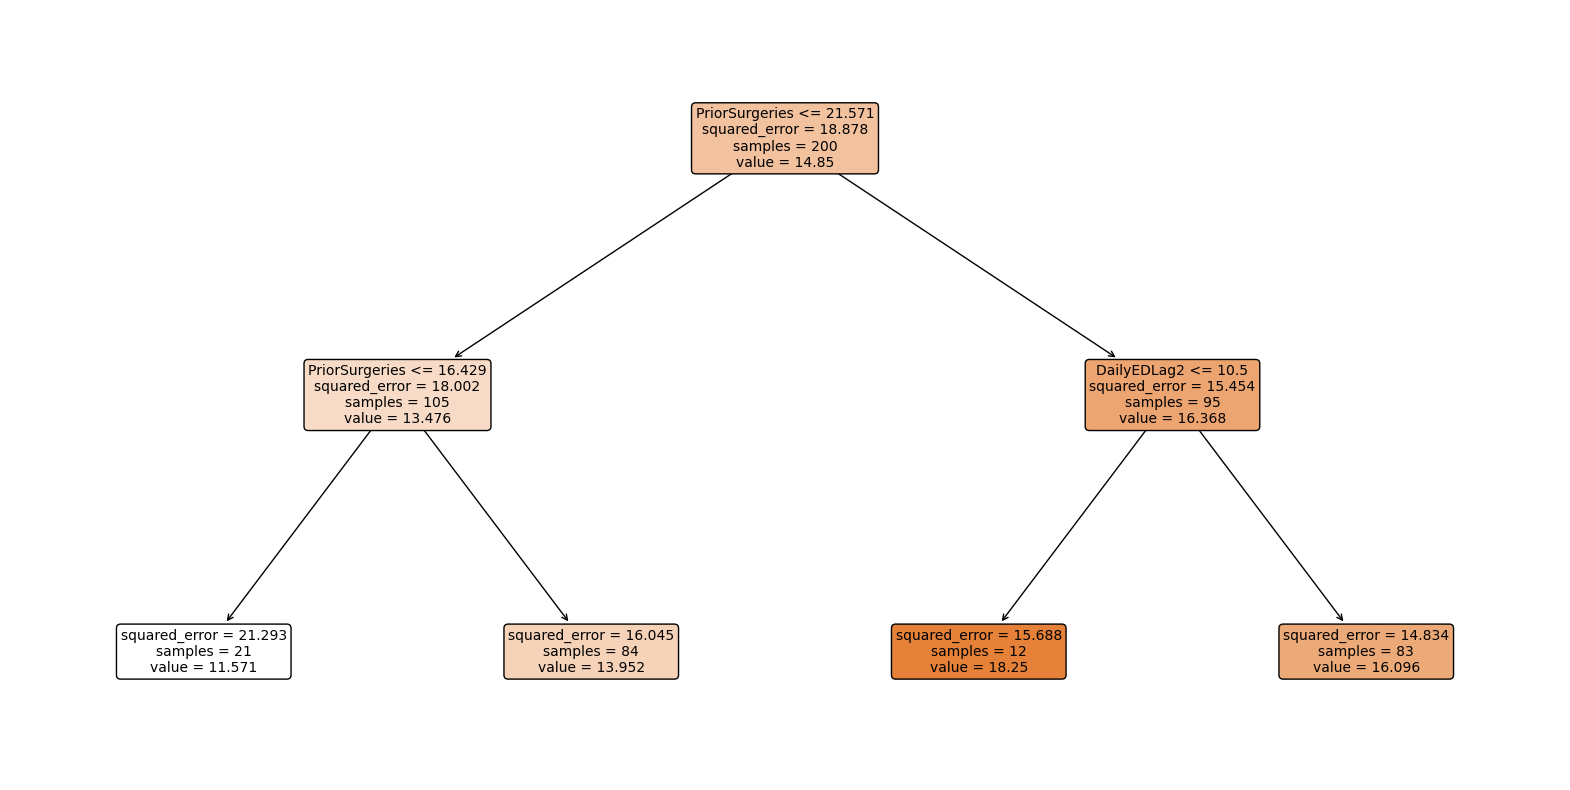

In [141]:
X_train = train.drop(columns=['Day', 'DailyED', 'Cost'])
y_train = train['DailyED']
tree = DecisionTreeRegressor(max_depth=2)
tree.fit(X_train, y_train)
tree_features = X_train.columns[tree.tree_.feature]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=list(X_train.columns), filled=True, rounded=True, fontsize=10)
plt.show()

a) What variables does your tree split on?

My tree splits on the variables 'PriorSurgeries' and 'DailyEDLag2'

b) For each leaf of the tree, calculate the optimal staffing level (rounded to the nearest integer) for the corresponding conditional distribution of DailyED given the training set. What is the optimal staffing level for each leaf of your tree?


In [142]:
train['leaf'] = tree.apply(X_train)
train['optimal_staffing'] = train.groupby('leaf').DailyED.transform(lambda x: x.quantile(0.6))
for leaf in train.leaf.unique():
    print(f'Leaf {leaf} has an optimal staffing level of {train[train.leaf == leaf].DailyED.quantile(0.6):.0f}')

Leaf 5 has an optimal staffing level of 18
Leaf 6 has an optimal staffing level of 17
Leaf 3 has an optimal staffing level of 15
Leaf 2 has an optimal staffing level of 13


c) Based on the training set, what is the average cost, where the average is taken over the 200 days in the training set, that this staffing rule would incur? (Make sure your cost accounts for the unavoidable cost component from Part 1 (d).)

In [143]:
train['Cost'] = train.apply(lambda row: staffing(row.DailyED, row.optimal_staffing), axis=1)
print(f'The average staffing cost for the training data is ${train.Cost.mean():.2f}')

The average staffing cost for the training data is $40556.16


d) Based on the test set, what is the average cost, where the average is taken over the 100 days in the test set, that this staffing rule would incur? (Make sure your cost accounts for the unavoidable cost component from Part 1 (d).)

In [144]:
X_test = test.drop(columns=['Day', 'DailyED', 'Cost'])
y_test = test['DailyED']
test['leaf'] = tree.apply(X_test)
test['optimal_staffing'] = test.leaf.map(train.groupby('leaf').optimal_staffing.first())
test['Cost'] = test.apply(lambda row: staffing(row.DailyED, row.optimal_staffing), axis=1)
print(f'The average staffing cost for the testing data is ${test.Cost.mean():.2f}')

The average staffing cost for the testing data is $38765.52


**<font size="5">2. Cargo freight scheduling</font>**

In [145]:
cargo_locations = pd.read_csv('cargo_locations.csv')

A freight company operating out of Los Angeles, CA needs to make a number of deliveries by air to a set of cities in the continental United States. Each city corresponds to one delivery.
The company has a single DC-10-30 aircraft available to make these deliveries, and needs to decide in what order to make deliveries (i.e., in what order to visit these cities) so as to minimize the time traveled. The aircraft departs from Los Angeles, and must return to Los Angeles after visiting all of the remaining 67 cities. Each city must be visited exactly once.
You are provided a data set (cargo-city-locations.csv) consisting of the locations of the cities by their latitude and longitude coordinates. There are 68 cities, including Los Angeles.

**<font size="4">Part 1: Building our data</font>**

In order to solve the problem, we will need to calculate the flight time between each pair of cities in the data set. We will do this by applying a little bit of geometry.

For each pair of cities i and j, first convert the latitudes lati and longitudes loni, which are given in degrees, to radians:

$LAT_{r, i} = \frac{LAT_i}{360} \times 2\pi$ 

$LON{r, i} = \frac{LON_i}{360} \times 2\pi$ 

$LAT_{r, j} = \frac{LAT_j}{360} \times 2\pi$ 

$LON{r, j} = \frac{LON_j}{360} \times 2\pi$

Then, we will use the haversine formula to calculate the angle corresponding to the great circle distance (see Figure 1 below) between cities i and j. The haversine Hi,j of cities i and j can be calculated as

where r is the radius of the earth, which we can assume to be 6378.137 km.

Lastly, you can use the fact that the average cruise speed of a DC-10 aircraft is 908 km / hour to convert these distances into travel times. This will yield us an approximate travel time between
each pair of cities.

To help you with these calculations you can use the numpy functions cos, sin, arcsin (the arcsine function, which is just the inverse sine function sin−1(·)) and sqrt (the square root).

To verify that you have implemented your distance calculations correctly, you should find that the travel time from Des Moines, IA to Baton Rouge, LA is 1.3857 hours, corresponding to a distance of 1258.226 kilometers.

In [146]:
cargo_locations.Latitude = cargo_locations.Latitude/360*2*np.pi
cargo_locations.Longitude = cargo_locations.Longitude/360*2*np.pi

In [147]:
## Defining functions
# Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    h = (1-np.cos(dlat))/2 + np.cos(lat1)*np.cos(lat2)*(1-np.cos(dlon))/2
    return h

# Distance formula
def distance(lat1, lon1, lat2, lon2, r = 6378.137):
    h = haversine(lat1, lon1, lat2, lon2)
    return 2*r*np.arcsin(np.sqrt(h))

# Travel time formula
def travel_time(lat1, lon1, lat2, lon2, speed = 908):
    return distance(lat1, lon1, lat2, lon2)/speed

In [148]:
# Des Moines to Baton Rouge
lat1 = cargo_locations.loc[cargo_locations.City == 'Des Moines'].Latitude.values[0]
lon1 = cargo_locations.loc[cargo_locations.City == 'Des Moines'].Longitude.values[0]
lat2 = cargo_locations.loc[cargo_locations.City == 'Baton Rouge'].Latitude.values[0]
lon2 = cargo_locations.loc[cargo_locations.City == 'Baton Rouge'].Longitude.values[0]
distance(lat1, lon1, lat2, lon2), travel_time(lat1, lon1, lat2, lon2)

(1258.2261386316286, 1.3857116064224984)

a) Which two cities have the highest travel travel time?

In [149]:
matrix = pd.DataFrame(np.zeros((len(cargo_locations), len(cargo_locations))), index = cargo_locations.City, columns = cargo_locations.City)
for i in range(len(cargo_locations)):
    for j in range(len(cargo_locations)):
        if i == j:
            matrix.iloc[i, j] = np.nan
        else:
            lat1 = cargo_locations.iloc[i].Latitude
            lon1 = cargo_locations.iloc[i].Longitude
            lat2 = cargo_locations.iloc[j].Latitude
            lon2 = cargo_locations.iloc[j].Longitude
            matrix.iloc[i, j] = travel_time(lat1, lon1, lat2, lon2)

In [150]:
# Find maximum travel time
max_time = np.nanmax(matrix.values)
start = matrix.loc[matrix.values == max_time].index[0]
end = matrix.loc[matrix.values == max_time].index[1]
print(f'The longest travel time is {max_time:.2f} hours from {start} to {end}')

The longest travel time is 9.07 hours from Honolulu to Augusta


b) Which two cities have the smallest travel time?

In [151]:
# Find maximum travel time
min_time = np.nanmin(matrix.values)
start = matrix.loc[matrix.values == min_time].index[0]
end = matrix.loc[matrix.values == min_time].index[1]
print(f'The shortest travel time is {min_time:.2f} hours from {start} to {end}')

The shortest travel time is 0.05 hours from Trenton to Philadelphia


c) Which city has the smallest average travel time to all of the other cities? (Here, the average is taken over the other 67 cities.)

In [152]:
print(f'The city with shortest average travel time to all other cities is {matrix.mean().idxmin()}')

The city with shortest average travel time to all other cities is Springfield


**<font size="4">Part 2: Finding a schedule</font>**

a) Suppose that we randomly selected a sequence of cities. In numpy, you can construct a random sequence by using the commands

       import numpy as np
       nCities = 68
       temp = np.random.permutation(nCities)

which will generate a list with the integers from 0 to 67 in random order. You can then calculate the travel time by iterating through the list and looking up the travel time of consecutive cities in the list, and adding them up. At the end, you would finally add the travel time corresponding to traveling from city temp[67] to city temp[0].


Set your seed to 50. Randomly generate 100 sequences of the 68 cities, and calculate the total travel time required to visit the cities according to each sequence. What is the average of the total travel times of these 100 randomly generated sequences, in hours?

In [153]:
# Generating 100 random permutations
nCities = len(cargo_locations)
np.random.seed(50)
total_times = []
for i in range(100):
    temp = np.random.permutation(nCities)
    temp = np.append(temp, temp[0])
    time = 0
    # Calculating travel times
    for j in range(len(temp) - 1):
        time += matrix.iloc[temp[j], temp[j+1]]
    total_times.append(time)

print(f'The average travel time is {np.mean(total_times):.2f} hours')


The average travel time is 149.46 hours


b) Suppose that we design the sequence of cities using the following heuristic. Starting from Los Angeles, the next city in the schedule is the one that is closest to the current city in travel time and has not been visited yet. What is the total travel time of this sequence, in hours?

In [154]:
# Algorithm
def heuristic_tour(matrix):
    cities = list(matrix.index)
    current = cities.pop(cities.index('Los Angeles'))
    tour = [current]
    time = 0

    while cities:
        next = matrix.loc[tour[-1], matrix.columns.isin(cities)].idxmin(skipna=True)
        current = cities.pop(cities.index(next))
        time += matrix.loc[tour[-1], next]
        tour.append(next)

    time += matrix.loc[tour[-1], tour[0]]
    return tour, time

tour, time = heuristic_tour(matrix)

print(f'The heuristic tour has a total travel time of {time:.2f} hours')

The heuristic tour has a total travel time of 35.85 hours


c) Solve an optimization problem to find the order in which the cities should be visited, so as to minimize the total travel time. What is the total travel time of this sequence, in hours?

In [155]:
######################################################
# Input Variables
nCities = 68
od = [(i, j) for i in range(len(matrix.index)) for j in range(len(matrix.columns)) if i != j]
times = {(i, j): matrix.iloc[i, j] for i, j in od}
od_pairs = list(times.keys())

######################################################
# Necessary Functions
def getSubtours(sequence):
    subtour_list = []
    unvisited = list(range(nCities))
    
    while ( len(unvisited) > 0 ):
        node = unvisited.pop()
        
        subtour = []
        subtour.append(node)
        
        next_node = list(filter(lambda t: t[0] == node, sequence))[0][1]
        
        while (next_node in unvisited):
            subtour.append(next_node)
            unvisited.remove(next_node)
            next_node = list(filter(lambda t: t[0] == next_node, sequence))[0][1]
            
        subtour_list.append(subtour)
    
    return subtour_list

def eliminateSubtours(model, where):
    if (where == GRB.Callback.MIPSOL):
        x_val = model.cbGetSolution(x)
        sequence = [ (i,j) for (i,j) in od_pairs if x_val[i,j] > 0.5]
        subtour_list = getSubtours(sequence)
        if (len(subtour_list) > 1):
            for subtour in subtour_list:
                model.cbLazy( sum(x[i,j] for i in subtour for j in subtour if i != j) <= len(subtour) - 1)

######################################################
# Optimization Model       
from gurobipy import *
m = Model()
m.setParam('OutputFlag', 0)

# Decision Variables
x = m.addVars(od_pairs, vtype = GRB.BINARY)

# Constraints
for i in range(nCities):
    m.addConstr( sum(x[i,j] for j in range(nCities) if i != j ) == 1)
    m.addConstr( sum(x[j,i] for j in range(nCities) if i != j ) == 1)

# Objective Function
m.setObjective(sum( times[i,j] * x[i,j] for (i,j) in od_pairs ), GRB.MINIMIZE)

# Optimize
m.update()

# Enable lazy constraints
m.params.LazyConstraints = 1

# Supply the callback to Gurobi:
m.optimize(eliminateSubtours)

######################################################
# Extracting the optimal time
print(f'The optimal tour has a total travel time of {m.ObjVal:.2f} hours')

The optimal tour has a total travel time of 30.55 hours
